## **CNN Model training on CIFAR Dataset**

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchsummary import summary
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time

### **Data Preparation by creating transformation pipeline on the fly**
1. Creating Data transformation pipeline using transform Compose.
2. Basic transformation like padding, croping, rotation, fliping, normalizing and converting PLI image to tensor object.
3. Download data for pytorch datasets 

In [ ]:
# Some commonly used transformations for the training set
transform_train = transforms.Compose([
    transforms.Pad(2),                                   # Pading images by 2 pixels
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # Random crop and resize
    transforms.RandomHorizontalFlip(),                   # Random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Adjust brightness and contrast
    transforms.RandomRotation(15),                       # Random rotation by 15 degrees
    transforms.ToTensor(),                               # Convert to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465),       # Normalizing 
                       (0.2470, 0.2435, 0.2616)),
    transforms.RandomErasing(p=0.5)                      # Random erasing
])

# Download and load the CIFAR-10 dataset and performing transformation on the fly
batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified


## **Creating Custome CNN model**

Custom model provide freedom to change and update model based of the requirement. It consists of two part first initialization under __init__() function and call function names forward() (in this model). whenever the model is called this call function is automatically called and data flow and all the computaiton under convolution operation and fully connected layer is performed. All the layers are called in sequential model from first layer which conv1 to last layer fc2 which is also called output layer. One layer's output is other layer's input.
1. Consists of 4 CNN layer.
2. Consists of 3 Activation function ReLU, Tanh and Sigmoid.
3. Perform Batch Normalization
4. And eventually perform Pooling operation to reduce the size of image.
5. Output of last CNN layer is flattern to 1D befor feeding it to fully connected dense layer.

In [ ]:
# Define the CNN architecture with customizable activation function
class CNN_CIFAR10(nn.Module):
    def __init__(self, activation_fn):
        super(CNN_CIFAR10, self).__init__()
        
        # Layer 1: Convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.activation = activation_fn
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        # Layer 2: Convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        # Layer 3: Convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Layer 4: Convolutional layer
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)  # 10 classes for CIFAR-10
    
    def forward(self, x):
        # Layer 1
        x = self.pool1(self.activation(self.bn1(self.conv1(x))))
        # Layer 2
        x = self.pool2(self.activation(self.bn2(self.conv2(x))))
        # Layer 3
        x = self.activation(self.bn3(self.conv3(x)))
        # Layer 4
        x = self.pool4(self.activation(self.bn4(self.conv4(x))))
        # Fully connected layers
        x = self.flatten(x)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

**Calculating the model parameters by generating the summary**
Model Parameters are the most important elemet of any model. These parameters determing how deep or complex the model is. Parameters plays an important role in model accuracy and performance. In Pytorch model summary are not availbale until you specify input size. In the model definition only the channels are specified no spatial dimention provided. So to know the no of parameter of modle an input is provided separatly so that model compute the total no. of parametes for the given input size.

In [ ]:
# Generate model parameter report
model = CNN_CIFAR10(nn.ReLU())
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
      BatchNorm2d-10            [-1, 128, 8, 8]             256
             ReLU-11            [-1, 128, 8, 8]               0
           Conv2d-12            [-1, 128, 8, 8]         147,584
      BatchNorm2d-13            [-1, 128, 8, 8]             256
             ReLU-14            [-1, 12

**Selecting Computing Resource based on the hardware use during Computation**
For large dataset computing resource is very important. Model training over GPU's are much faster compared on CPU's. However due to the resource constrained this model is trained on CPU. GPU settings can be enabled befor starting model training.

In [34]:
# Initialize device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## **Training model using SGD as an Optimization algorithm**

Model are trained twice using every activation function ReLU, tanh and Sigmoid. So the Optimization algorithm is changed on different run for same activation function.

**Model Training using ReLU Activation**

In [ ]:
# For storing error and time values for each epoch during training.
training_errors_sgd = {}
training_times_sgd = {}

In [ ]:
# Crearte an instance of custom model CNN_CIFAR10 
# define the loss function and the optimizer

relu_model = CNN_CIFAR10(nn.ReLU()).to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(relu_model.parameters(), lr=0.001)
optimizer = optim.SGD(relu_model.parameters(), lr=0.01, momentum=0.9)

NameError: name 'CNN_CIFAR10' is not defined

In [ ]:
training_error = 100.0
epoch = 0
relu_epoch_times = []
relu_epoch_errors = []

while training_error > 25.0:
    epoch += 1
    start_time = time.time()

    # Initializing counters for correct predictions. Initial initialization is 0 for both counters
    correct = 0
    total = 0

    # Taking the data in batch of 128 from trainloader to train 
    # Device is selected as CPU or GPU
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        # inputs batch is fed into the model here relu 
        # output of the model is check for accuracy.
        # backpropagation is performed to compute parameters using gradient 
        # descent algorithm (here SDG with momentum) 
        optimizer.zero_grad()
        outputs = relu_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculating accuracy
        # get prediction class and count the total and coorrectly predicted sample 
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # calulating training error in percentage
    training_error = 100 - (100 * correct / total)

    # measuring time talen by epoch
    epoch_time = time.time() - start_time
    relu_epoch_times.append(epoch_time)
    relu_epoch_errors.append(training_error)

    # Storing results in the respective distionary
    training_errors_sgd['relu_epoch_errors'] = relu_epoch_errors
    training_times_sgd['relu_epoch_times'] = relu_epoch_times    

    print(f'ReLU - Epoch {epoch}: Training Error = {training_error:.2f}%, Time = {epoch_time:.2f}s')


ReLU - Epoch 1: Training Error = 61.75%, Time = 71.21s
ReLU - Epoch 2: Training Error = 51.24%, Time = 70.19s
ReLU - Epoch 3: Training Error = 45.68%, Time = 71.87s
ReLU - Epoch 4: Training Error = 42.54%, Time = 74.46s
ReLU - Epoch 5: Training Error = 40.15%, Time = 73.64s
ReLU - Epoch 6: Training Error = 37.85%, Time = 70.61s
ReLU - Epoch 7: Training Error = 36.25%, Time = 66.79s
ReLU - Epoch 8: Training Error = 34.87%, Time = 74.09s
ReLU - Epoch 9: Training Error = 33.53%, Time = 70.05s
ReLU - Epoch 10: Training Error = 32.31%, Time = 68.30s
ReLU - Epoch 11: Training Error = 31.75%, Time = 70.15s
ReLU - Epoch 12: Training Error = 30.66%, Time = 70.80s
ReLU - Epoch 13: Training Error = 29.88%, Time = 70.08s
ReLU - Epoch 14: Training Error = 29.55%, Time = 72.28s
ReLU - Epoch 15: Training Error = 28.30%, Time = 79.73s
ReLU - Epoch 16: Training Error = 27.98%, Time = 79.80s
ReLU - Epoch 17: Training Error = 27.47%, Time = 73.84s
ReLU - Epoch 18: Training Error = 26.79%, Time = 92.60s
R

**Training with Tanh Activation**

In [57]:
tanh_model = CNN_CIFAR10(nn.Tanh()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(tanh_model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
training_error = 100.0
epoch = 0
tanh_epoch_times = []
tanh_epoch_errors = []

while training_error > 25.0:
    epoch += 1
    start_time = time.time()

    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = tanh_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    training_error = 100 - (100 * correct / total)
    epoch_time = time.time() - start_time
    tanh_epoch_times.append(epoch_time)
    tanh_epoch_errors.append(training_error)

    
    # Storing results
    training_errors_sgd['tanh_epoch_errors'] = tanh_epoch_errors
    training_times_sgd['tanh_epoch_times'] = tanh_epoch_times    

    print(f'Tanh - Epoch {epoch}: Training Error = {training_error:.2f}%, Time = {epoch_time:.2f}s')


Tanh - Epoch 1: Training Error = 60.52%, Time = 67.80s
Tanh - Epoch 2: Training Error = 51.70%, Time = 66.82s
Tanh - Epoch 3: Training Error = 48.18%, Time = 73.54s
Tanh - Epoch 4: Training Error = 44.75%, Time = 71.63s
Tanh - Epoch 5: Training Error = 42.85%, Time = 62.58s
Tanh - Epoch 6: Training Error = 41.75%, Time = 68.79s
Tanh - Epoch 7: Training Error = 40.25%, Time = 66.17s
Tanh - Epoch 8: Training Error = 39.16%, Time = 68.86s
Tanh - Epoch 9: Training Error = 38.02%, Time = 79.72s
Tanh - Epoch 10: Training Error = 37.07%, Time = 95.21s
Tanh - Epoch 11: Training Error = 36.96%, Time = 94.41s
Tanh - Epoch 12: Training Error = 35.91%, Time = 96.15s
Tanh - Epoch 13: Training Error = 35.38%, Time = 97.71s
Tanh - Epoch 14: Training Error = 34.89%, Time = 96.76s
Tanh - Epoch 15: Training Error = 34.46%, Time = 96.14s
Tanh - Epoch 16: Training Error = 33.80%, Time = 80.68s
Tanh - Epoch 17: Training Error = 33.21%, Time = 92.96s
Tanh - Epoch 18: Training Error = 32.78%, Time = 71.93s
T

**Training with Sigmoid Activation**

In [60]:
sigmoid_model = CNN_CIFAR10(nn.Sigmoid()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(sigmoid_model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
training_error = 100.0
epoch = 0
sigmoid_epoch_times = []
sigmoid_epoch_errors = []

while training_error > 25.0:
    epoch += 1
    start_time = time.time()

    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = sigmoid_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    training_error = 100 - (100 * correct / total)
    epoch_time = time.time() - start_time
    sigmoid_epoch_times.append(epoch_time)
    sigmoid_epoch_errors.append(training_error)

    # Storing results
    training_errors_sgd['sigmoid_epoch_errors'] = sigmoid_epoch_errors
    training_times_sgd['sigmoid_epoch_times'] = sigmoid_epoch_times
    

    print(f'Sigmoid - Epoch {epoch}: Training Error = {training_error:.2f}%, Time = {epoch_time:.2f}s')


Sigmoid - Epoch 1: Training Error = 78.96%, Time = 51.39s
Sigmoid - Epoch 2: Training Error = 67.59%, Time = 56.01s
Sigmoid - Epoch 3: Training Error = 62.78%, Time = 60.24s
Sigmoid - Epoch 4: Training Error = 59.16%, Time = 66.89s
Sigmoid - Epoch 5: Training Error = 56.79%, Time = 183.71s
Sigmoid - Epoch 6: Training Error = 54.89%, Time = 102.25s
Sigmoid - Epoch 7: Training Error = 53.13%, Time = 100.63s
Sigmoid - Epoch 8: Training Error = 51.79%, Time = 90.72s
Sigmoid - Epoch 9: Training Error = 50.05%, Time = 99.27s
Sigmoid - Epoch 10: Training Error = 49.27%, Time = 104.04s
Sigmoid - Epoch 11: Training Error = 48.03%, Time = 106.68s
Sigmoid - Epoch 12: Training Error = 47.25%, Time = 101.03s
Sigmoid - Epoch 13: Training Error = 45.79%, Time = 101.63s
Sigmoid - Epoch 14: Training Error = 44.63%, Time = 100.35s
Sigmoid - Epoch 15: Training Error = 44.52%, Time = 100.55s
Sigmoid - Epoch 16: Training Error = 43.92%, Time = 96.44s
Sigmoid - Epoch 17: Training Error = 42.86%, Time = 95.5

**Error and Time Visualization**

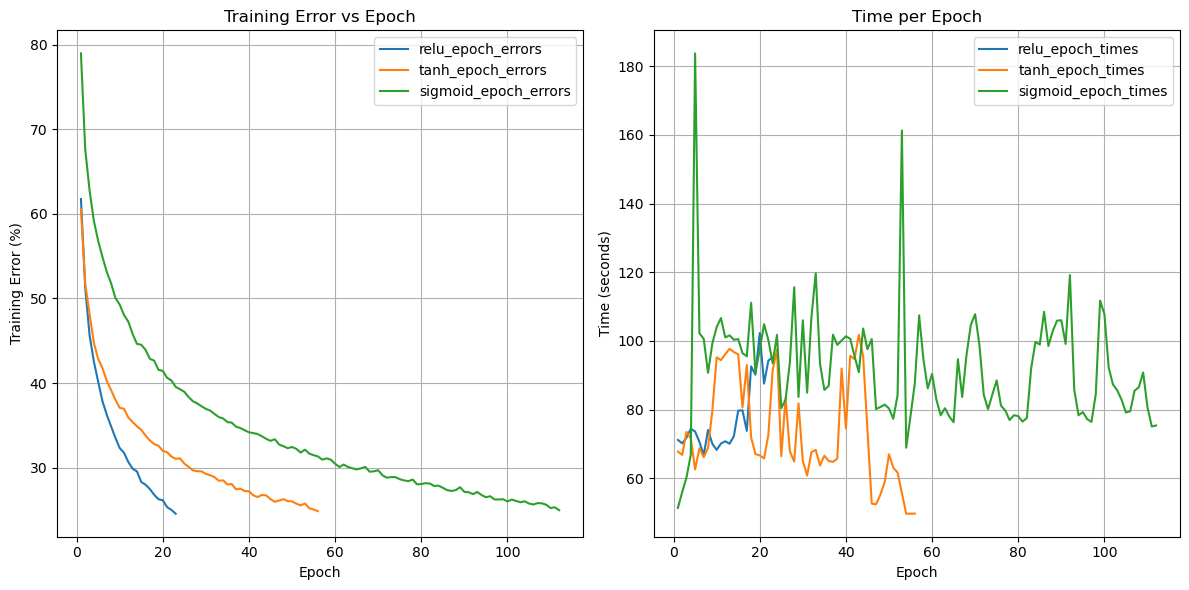

In [124]:
# Plot epoch times and training errors for all activation functions
plt.figure(figsize=(12, 6))

# Plot training error vs epoch
plt.subplot(1, 2, 1)
for activation_name, errors in training_errors_sgd.items():
    plt.plot(range(1, len(errors) + 1), errors, label=activation_name)

plt.xlabel('Epoch')
plt.ylabel('Training Error (%)')
plt.title('Training Error vs Epoch')
plt.legend()
plt.grid()

# Plot time vs epoch
plt.subplot(1, 2, 2)
for activation_name, times in training_times_sgd    .items():
    plt.plot(range(1, len(times) + 1), times, label=activation_name)

plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.title('Time per Epoch')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### **Training model using Adam as a optimization algorithm**

In [ ]:
# For storing scores for all activation functions
training_errors_adam = {}
training_times_adam = {}

In [ ]:
# Training Function
def train_model(activation_name, activation_fn):
    print(f"\nTraining with {activation_name} activation function...")

    # Initialize model, loss function, and optimizer
    model = CNN_CIFAR10(activation_fn).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)   # Adam optimizer

    # Training loop
    training_error = 100.0
    epoch = 0
    epoch_times = []
    epoch_errors = []

    while training_error > 25.0:
        epoch += 1
        start_time = time.time()

        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        training_error = 100 - (100 * correct / total)
        epoch_time = time.time() - start_time
        epoch_times.append(epoch_time)
        epoch_errors.append(training_error)

        print(f'{activation_name} - Epoch {epoch}: Training Error = {training_error:.2f}%, Time = {epoch_time:.2f}s')

    # Storing results
    training_errors_adam[activation_name] = epoch_errors
    training_times_adam[activation_name] = epoch_times

**Training Model**

In [76]:
# Train with Different Activation Functions using Adam Optimizer
train_model("ReLU", nn.ReLU())
train_model("Tanh", nn.Tanh())
train_model("Sigmoid", nn.Sigmoid())


Training with ReLU activation function...
ReLU - Epoch 1: Training Error = 62.37%, Time = 78.39s
ReLU - Epoch 2: Training Error = 50.86%, Time = 75.72s
ReLU - Epoch 3: Training Error = 45.82%, Time = 77.01s
ReLU - Epoch 4: Training Error = 42.07%, Time = 76.12s
ReLU - Epoch 5: Training Error = 39.61%, Time = 80.30s
ReLU - Epoch 6: Training Error = 37.82%, Time = 51.79s
ReLU - Epoch 7: Training Error = 35.81%, Time = 47.18s
ReLU - Epoch 8: Training Error = 34.54%, Time = 51.22s
ReLU - Epoch 9: Training Error = 33.67%, Time = 56.78s
ReLU - Epoch 10: Training Error = 32.51%, Time = 64.51s
ReLU - Epoch 11: Training Error = 31.50%, Time = 79.41s
ReLU - Epoch 12: Training Error = 30.77%, Time = 80.66s
ReLU - Epoch 13: Training Error = 30.06%, Time = 79.18s
ReLU - Epoch 14: Training Error = 29.59%, Time = 80.25s
ReLU - Epoch 15: Training Error = 28.76%, Time = 78.53s
ReLU - Epoch 16: Training Error = 27.86%, Time = 77.75s
ReLU - Epoch 17: Training Error = 27.89%, Time = 78.74s
ReLU - Epoch 1

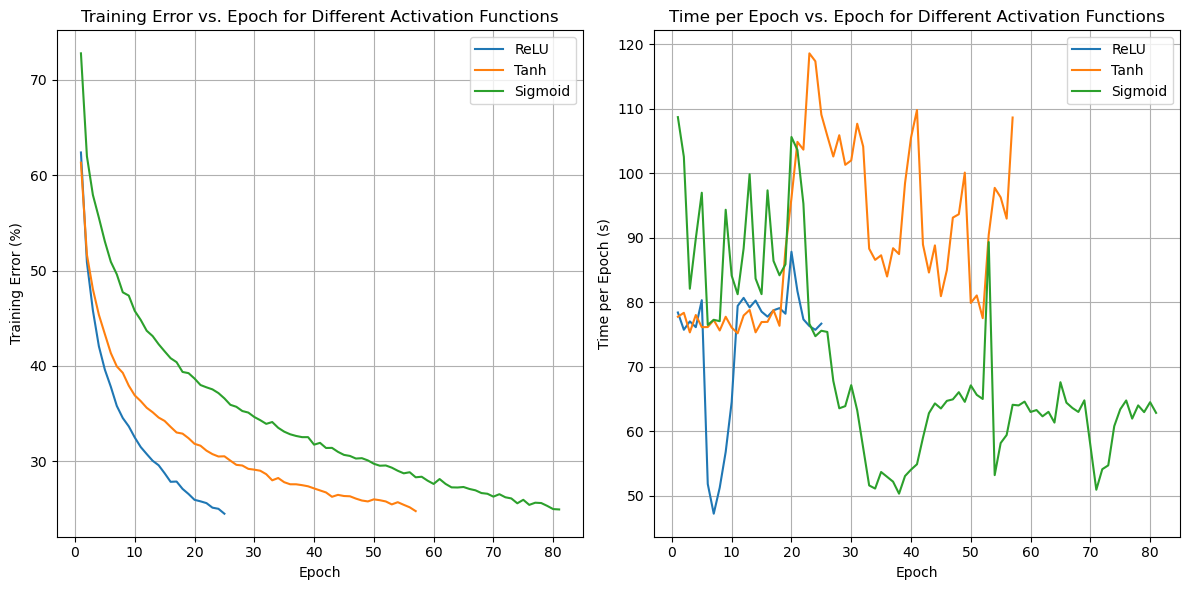

In [100]:
# Plot epoch times and training errors for all activation functions
plt.figure(figsize=(12, 6))

# Plot training error vs epoch
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
for activation_name, errors in training_errors_adam.items():
    plt.plot(range(1, len(errors) + 1), errors, label=activation_name)

plt.xlabel("Epoch")
plt.ylabel("Training Error (%)")
plt.title("Training Error vs. Epoch for Different Activation Functions")
plt.legend()
plt.grid(True)

# Plot time vs epoch
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
for activation_name, times in training_times_adam.items():
    plt.plot(range(1, len(times) + 1), times, label=activation_name)

plt.xlabel("Epoch")
plt.ylabel("Time per Epoch (s)")
plt.title("Time per Epoch vs. Epoch for Different Activation Functions")
plt.legend()
plt.grid(True)

# Display the figure with both subplots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()